In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs import FITSFixedWarning
from astropy.io.fits.verify import VerifyWarning

import time
from datetime import datetime
from copy import deepcopy
import os
from itertools import compress

from tqdm import tqdm

from mocpy import MOC
# from mocpy import WCS as mocWCS

from billiard.pool import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

import warnings # To ignore our problems
warnings.simplefilter('ignore', category=VerifyWarning)
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib widget

In [2]:
def max_radius(ra1, dec1, ra2, dec2):
    return np.nanmax(angular_distance(ra1, dec1, ra2, dec2))

def angular_distance(ra1, dec1, ra2, dec2):
    d1 = np.sin(np.radians(dec1)) * np.sin(np.radians(dec2))
    d2 = np.cos(np.radians(dec1)) * np.cos(np.radians(dec2)) * np.cos(np.radians(ra1 - ra2))
    return np.degrees(np.arccos(d1 + d2))

In [3]:
skycell = 'skycell.2246.021'
skycell_index = 952

skycell_csv = './skycell_coordinates.csv'
skycell_df = pd.read_csv(skycell_csv)

skycell_wcs_csv = './SkyCells/skycell_wcs.csv'
skycell_wcs_df = pd.read_csv(skycell_wcs_csv)

buffer = 120

In [4]:
# TESS Stuff

im1_file = './PS1_to_TESS/data/tess2019359002923-s0020-1-1-0165-s_ffic.fits'

hdul = fits.open(im1_file)
try:
    temp_copy = deepcopy(hdul[1].header)
except:
    temp_copy = deepcopy(hdul[0].header)
super_data = hdul[1].data
data_shape = np.shape(super_data)
super_wcs = WCS(hdul[1].header)
im1_poly = super_wcs.calc_footprint()
hdul.close()

ra_centre, dec_centre = super_wcs.all_pix2world(data_shape[0]//2, data_shape[1]//2, 0)

In [5]:
# TESS Ravelling

t_y, t_x = data_shape
_ty, _tx = np.mgrid[:t_y, :t_x]

ty_input = _ty.ravel()
tx_input = _tx.ravel()

tpix_coord_input = np.column_stack([ty_input, tx_input])

_x_im1 = tpix_coord_input[:,1]
_y_im1 = tpix_coord_input[:,0]
_ra_im1, _dec_im1 = super_wcs.all_pix2world(_x_im1, _y_im1, 0)

ravelled_indices = np.array([(i, j) for i in range(data_shape[0]) for j in range(data_shape[1])])

In [6]:
# Grabbing the skycells

ra_corners = im1_poly[:, 0]
dec_corners = im1_poly[:, 1]

radius_var = max_radius(ra_centre, dec_centre, ra_corners, dec_corners) + np.sqrt(2) * 0.4

radius = angular_distance(ra_centre, dec_centre, skycell_df['RA'].to_numpy(), skycell_df['DEC'].to_numpy())

mask = radius < radius_var

skycells_list = skycell_df[mask].Name.to_numpy()
skycells_id = np.arange(len(skycells_list))

complete_skycells = deepcopy(skycell_df[mask].reset_index(drop=True))
complete_wcs_skycells = deepcopy(skycell_wcs_df[mask].reset_index(drop=True))


complete_skycells['NAXIS1'] = complete_wcs_skycells['NAXIS1']
complete_skycells['NAXIS2'] = complete_wcs_skycells['NAXIS2']

In [7]:
# PS1 WCS and Polygons

temp = skycell_df[skycell_df['Name'] == skycell].reset_index(drop=True)
other_temp = skycell_wcs_df[skycell_wcs_df['NAME'] == skycell].reset_index(drop=True)

records = other_temp.to_dict(orient='records')
header_dict = {k: v for d in records for k, v in d.items()}

temp_head = fits.Header(header_dict)
ps1_data_shape = (other_temp['NAXIS2'].iloc[0], other_temp['NAXIS1'].iloc[0])
    
ps1_wcs = WCS(temp_head)

# ra_corners_ps1 = np.array([temp[f'RA_Corner{i}'] for i in range(1, 5)])
# dec_corners_ps1 = np.array([temp[f'DEC_Corner{i}'] for i in range(1, 5)])

corns = np.array([[buffer, buffer], [ps1_data_shape[1] - buffer, buffer], 
                  [ps1_data_shape[1] - buffer, ps1_data_shape[0] - buffer], 
                  [buffer, ps1_data_shape[0] - buffer]])

ra_corners_ps1, dec_corners_ps1 = ps1_wcs.all_pix2world(corns[:, 0], corns[:, 1], 0)

min_ps1_ra = np.min(ra_corners_ps1)
max_ps1_ra = np.max(ra_corners_ps1)

min_ps1_dec = np.min(dec_corners_ps1)
max_ps1_dec = np.max(dec_corners_ps1)

ps1_poly = np.column_stack((ra_corners_ps1, dec_corners_ps1))

ps1_poly

array([[120.41509339,  44.75868363],
       [119.82237406,  44.76900003],
       [119.83506983,  45.18874858],
       [120.43221417,  45.17827724]])

In [8]:
# TESS Polygons

pixel_vertices = []

mask = (_ra_im1 >= min_ps1_ra) & (_ra_im1 < max_ps1_ra) & (_dec_im1 >= min_ps1_dec) & (_dec_im1 < max_ps1_dec)
filtered_indices = np.where(mask)[0]

pix_centers = np.column_stack((_ra_im1[filtered_indices], _dec_im1[filtered_indices]))
pix_center_ra = _ra_im1[filtered_indices]
pix_center_dec = _dec_im1[filtered_indices]
im1_indices = ravelled_indices[filtered_indices]

for c in tpix_coord_input[filtered_indices]:
    x = c[1]
    y = c[0]

    upper_left = (x - 0.5, y - 0.5)
    upper_right = (x + 0.5, y - 0.5)
    lower_right = (x + 0.5, y + 0.5)
    lower_left = (x - 0.5, y + 0.5)

    t_poly = super_wcs.all_pix2world([upper_left, upper_right, lower_right, lower_left], 0)
    pixel_vertices.append(t_poly)

In [9]:
# PS1 Ravelling

p_y, p_x = ps1_data_shape

py, px = np.mgrid[:p_y, :p_x]

py_input = py.ravel()
px_input = px.ravel()


ppix_coord_input = np.column_stack((py_input, px_input))

x2 = ppix_coord_input[:,1]
y2 = ppix_coord_input[:,0]
_ra2, _dec2 = ps1_wcs.all_pix2world(x2, y2, 0)

(6289, 6307)
(6289, 6307)


In [10]:
# MOCPy Stuff

ps1_skycoord = SkyCoord(ps1_poly, unit="deg", frame="icrs")

ps1_moc = MOC.from_polygon_skycoord(ps1_skycoord, complement=False, max_depth=21)
ps1_mask = ps1_moc.contains_lonlat(pix_center_ra * u.degree, pix_center_dec * u.degree)

enc_pix_vertices = list(compress(pixel_vertices, ps1_mask))
enc_pix_center_ra = np.asarray(pix_center_ra)[ps1_mask]
enc_pix_center_dec = np.asarray(pix_center_dec)[ps1_mask]
enc_pix_indices = np.asarray(im1_indices)[ps1_mask]

enc_pix = []
for t in tqdm(enc_pix_vertices, desc='Encoding TESS Pixels'):
    pix_skycoord = SkyCoord(t, unit="deg", frame="icrs")
    tess_pix_moc = MOC.from_polygon_skycoord(pix_skycoord, complement=False, max_depth=21)
    enc_pix.append(tess_pix_moc)


Encoding TESS Pixels: 100%|██████████| 5398/5398 [00:07<00:00, 745.45it/s]


In [11]:
# Fitting Crap

pix_ras = _ra2
pix_decs = _dec2
poly = enc_pix_vertices

output = []

pix_indexs = np.arange(len(enc_pix))
tess_pix_mocs = deepcopy(enc_pix)
tess_inds = deepcopy(enc_pix_indices[pix_indexs])

if len(pix_indexs) != 0:

    for i in tqdm(range(len(pix_indexs)), desc='Fitting PS1 to TESS'):
        pix_index = pix_indexs[i]
        tess_ind = tess_inds[i]
        tess_pix_moc = tess_pix_mocs[i]

        tp = poly[pix_index]

        _min_ra, _max_ra = np.min(tp[:, 0]) - 0.05, np.max(tp[:, 0]) + 0.05
        _min_dec, _max_dec = np.min(tp[:, 1]) - 0.05, np.max(tp[:, 1]) + 0.05

        search_indices = np.where((pix_ras >= _min_ra) &
                                (pix_ras <= _max_ra) &
                                (pix_decs >= _min_dec) &
                                (pix_decs <= _max_dec))[0]

        enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(pix_ras[search_indices] * u.degree, pix_decs[search_indices] * u.degree)
        ps1_ind = np.arange(len(_ra2))
        ps1_ind = ps1_ind[search_indices][enc_ps1_pix_mask]

        temp_ra = np.asarray(pix_ras[search_indices])[enc_ps1_pix_mask]
        temp_dec = np.asarray(pix_decs[search_indices])[enc_ps1_pix_mask]

        output.append((tess_ind, temp_ra, temp_dec, ps1_ind))


Fitting PS1 to TESS: 100%|██████████| 5398/5398 [21:45<00:00,  4.13it/s]


In [12]:
pix_output = deepcopy(output)

In [13]:

fll = np.full((ps1_data_shape[0], ps1_data_shape[1], 2), np.nan)

for i in range(len(pix_output)):
    unravel_index = np.unravel_index(pix_output[i][-1], ps1_data_shape)
    length = len(unravel_index[0])
    zeros = np.zeros(length)
    tup = (unravel_index[0], unravel_index[1], zeros)

    fll[tup[0], tup[1], np.int16(tup[2])] = pix_output[i][0][1]
    fll[tup[0], tup[1], np.int16(tup[2]) + 1] = pix_output[i][0][0]

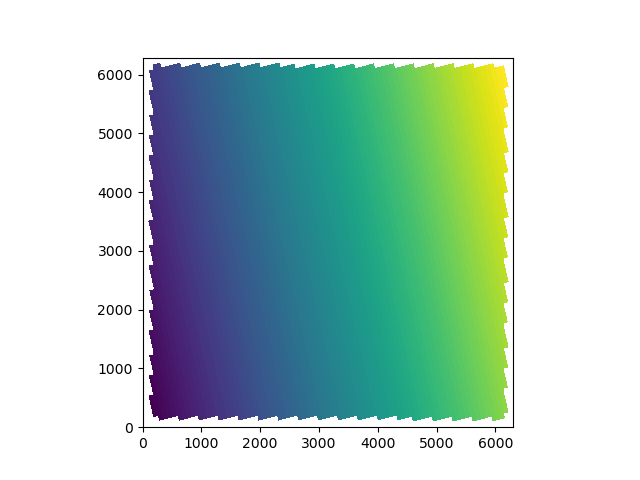

In [14]:
plt.figure()
plt.imshow(fll[:,:,0], origin='lower')
plt.show()

In [ ]:
plt.figure()
plt.imshow(fll[:,:,0], origin='lower')
plt.show()